# 1. Imports

In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import sys
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.cuda.amp import autocast, GradScaler
from datetime import datetime
#import onnx
#import onnxruntime as ort
from PIL import Image
import numpy as np


base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(base_dir)

sys.path.append(base_dir)

%matplotlib inline

c:\ProjetosPython\PICOS


# 2. Funcoes

In [42]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

class CustomTransform: # Transformação das imagens
    def __call__(self, img, target):
        if isinstance(img, torch.Tensor):
            return img.to(device), target  # Verifica se a imagem é tensor, caso seja já envia para o dispositivo

        img = transforms.ToTensor()(img)  # Caso não seja Tensor, transforma em tensor
        return img.to(device), target  # Envia a imagem para o dispositivo
    
class CustomDataset(CocoDetection): # Configuração do dataset personalizado
    def __init__(self, root, annotation, transforms=None):
        super().__init__(root, annotation)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        if self.transforms:
            img, target = self.transforms(img, target)  # Aplica a transformação na imagem e no target

        return img, target

def load_settings():
    """Função para ler as configurações de um arquivo .txt e atribuir os valores diretamente às variáveis."""
    # Valores padrão
    defaults = {
        'perc_top': 0.4,
        'perc_bottom': 0.8,
        'min_score': 0.5,
        'limit_center': 8,
        'save_dir': 'data\\outputs\\capturas',
        'square_size': 640,
        'grid_x': 0,
        'grid_y': 0,
        'crop_image': 1  # 1 = Sim
    }

    return (
        defaults['perc_top'],
        defaults['perc_bottom'],
        defaults['min_score'],
        defaults['limit_center'],
        defaults['save_dir'],
        defaults['square_size'],
        defaults['grid_x'],
        defaults['grid_y'],
        defaults['crop_image'],
    )

def create_model(weights, num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

def load_pretrained_model(device, model, pretrained_model_path):
    if pretrained_model_path and os.path.exists(pretrained_model_path):
        model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
        print(f"Modelo carregado de: {pretrained_model_path}")

    else:
        print("Treinando modelo do zero...")

    model.to(device)
    return model

def load_model_eval(device, model, pretrained_model_path):  # Colocar o modelo em modo de avaliação
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    model.to(device)
    model.eval() 
    
    return model

def dataset_config(images_dir, annotations_path, data_loader_batch_size):
    dataset = CustomDataset(
        root=os.path.join(base_dir, images_dir),
        annotation=os.path.join(base_dir, annotations_path),
        transforms=CustomTransform()  # Passa a transformação customizada
    )

    # Configuração do DataLoader
    data_loader = DataLoader(dataset, batch_size=data_loader_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

    return dataset, data_loader

def load_image_tensor(image_path):
    image = Image.open(image_path).convert("RGB")  # Carrega a imagem e converte para RGB
    transform = transforms.ToTensor()  # Define a transformação para ToTensor
    image_tensor = transform(image).unsqueeze(0)  # Converte a imagem para tensor e adiciona uma dimensão de batch
    
    return image_tensor

def rules_detection(frame, detections_sorted, perc_top, perc_bottom, min_score, limit_center):
    height, width = frame.shape[:2]

    # Define as posições das linhas
    line_limit_top = int(height * perc_top)    # Só conta quando a mediana entrar nesse range
    line_limit_bottom = int(height * perc_bottom)   # Só conta quando a mediana entrar nesse range
    dif_limit = line_limit_bottom - line_limit_top

    # Linha de limite superior
    cv2.line(frame, (0, line_limit_top), (frame.shape[1], line_limit_top), (0, 255, 0), 2)

    # Linha de limite inferior
    cv2.line(frame, (0, line_limit_bottom), (frame.shape[1], line_limit_bottom), (0, 255, 0), 2)

    line_top_median = None  # É calculada a mediana das detecções, e só são contados biscoitos que estão naquela mediana + - um valor de range
    line_bottom_median = None   # É calculada a mediana das detecções, e só são contados biscoitos que estão naquela mediana + - um valor de range

    # Lista para armazenar centros de detecções
    centers = []
    all_centers_y = ([])  # Lista para armazenar as coordenadas y dos centros detectados

    total_detections = 0  # Contador total de detecções

    ### CALCULO DA MEDIANA
    for idx, detection in enumerate(detections_sorted):
        score = detection[1]   # Pontuação de confiança
        x_min, y_min, x_max, y_max = detection[0]  # Coordenadas da caixa - y cresce de cima para baixo

        # Verificar se a pontuação é maior que o limite e se está entre as linhas de contagem
        if (score > min_score and y_max > line_limit_top and y_min < line_limit_bottom):
            center_y = (y_min + y_max) // 2   # Calcular o centro da caixa de detecção
            all_centers_y.append(center_y)  # Adiciona y à lista de centros

    if all_centers_y:
        median_y = int(np.median(all_centers_y))  # Obtém a mediana
        line_bottom_median = int(median_y + int((height * 0.3)) / 2)
        line_top_median = int(median_y - int((height * 0.3)) / 2)
        
        cv2.line(frame, (640, median_y), (640 + 640, median_y), (255, 0, 0), 2,)  # Desenhar a linha horizontal na media

    ### MARCACAO
    if ( all_centers_y and line_limit_bottom > median_y > line_limit_top):  # Se tiver pelo menos uma marcação dentro dos limites e a mediana for dentro dos limites
        for idx, detection in enumerate(detections_sorted):
            score = detection[1]   # Pontuação de confiança
            x_min, y_min, x_max, y_max = detection[0]  # Coordenadas da caixa - y cresce de cima para baixo

            center_x = int((x_min + x_max) // 2)   # Calcular o centro da caixa de detecção
            center_y = int((y_min + y_max) // 2)

            test_score = score > min_score   # Verifica score da deteccao
            test_center = not any(np.linalg.norm(np.array([center_x, center_y]) - np.array(center))< limit_center for center in centers)   # Verifica se está próximo de algum centro
            test_center_x = not any(abs(center_x - center[0]) < limit_center for center in centers)   # Verifica se está próximo de algum x dos centros
            test_median = (y_max > line_top_median and y_min < line_bottom_median)   # Verifica se está na mediana +- range

            if test_score and test_center and test_median:
                total_detections += 1
                # print(f"Deteccao {str(total_detections)} ({idx + 1}): {str(score)} - OK (Score: {test_score} / Center: {test_center} / Center X: {test_center_x} / Median: {test_median})")

                centers.append((center_x, center_y))  # Adiciona o centro à lista

                cv2.circle(frame, (center_x, center_y), limit_center, (0, 0, 255), -1)   # Desenhar uma bolinha (círculo) no centro

                cv2.circle(frame, (center_x, center_y), limit_center, (255, 0, 0), 1)  # Círculo vermelho de limite

                cv2.putText(frame,str(total_detections),(center_x - 6, center_y + 3),cv2.FONT_HERSHEY_SIMPLEX,0.35,(255, 255, 255),1)   # Colocar o número da marcação dentro da bolinha

    cv2.line(frame, (0, line_top_median), (640 + 640, line_top_median), (255, 0, 0), 2)
    cv2.line(frame,(0, line_bottom_median), (640 + 640, line_bottom_median), (255, 0, 0), 2)

    return frame, total_detections

def no_rules_detection(frame, detections_sorted, perc_top, perc_bottom, min_score, limit_center):
    total_detections = 0  # Contador total de detecções

    for idx, detection in enumerate(detections_sorted):
        score = detection[1]
        x_min, y_min, x_max, y_max = detection[0]

        center_x = int((x_min + x_max) // 2)
        center_y = int((y_min + y_max) // 2)

        total_detections += 1

        # Marca o centro com um círculo vermelho
        cv2.circle(
            frame,
            (center_x, center_y),
            7,
            (0, 0, 255),
            -1,
        )

        # Círculo azul indicando o raio que antes era o limit_center
        cv2.circle(
            frame,
            (center_x, center_y),
            limit_center,
            (255, 0, 0),
            1,
        )

        # Número da detecção
        cv2.putText(
            frame,
            str(total_detections),
            (center_x - 6, center_y + 3),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.35,
            (255, 255, 255),
            1,
        )

    # Área superior de fundo do texto
    cv2.rectangle(
        frame,
        (0, 0),
        (frame.shape[1], 40),
        (80, 43, 30),
        -1,
    )

    # Texto de total
    text = f'Total de Biscoitos: {total_detections}'
    cv2.putText(
        frame,
        text,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2,
    )

    return frame, total_detections

def visualize_predictions_image(print_images, device, model, image_tensor, coco_annotations=None, threshold=0.5, limit_center = 6, perc_top = 0.35, perc_bottom = 0.6):
    # Tratamento inicial das imagens
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image_detected = (image_np * 255).astype(np.uint8).copy()  # OpenCV usa 0-255
    image_annotated = image_np.copy()

    frame_bgr = cv2.cvtColor(image_detected, cv2.COLOR_RGB2BGR)

    # Regras nas anotacoes
    height, width = frame_bgr.shape[:2]
    line_limit_top = int(height * perc_top)    # Só conta quando a mediana entrar nesse range
    line_limit_bottom = int(height * perc_bottom)   # Só conta quando a mediana entrar nesse range

    coco_annotations_rules = []
    if coco_annotations:
        for ann in coco_annotations:
            x, y, w, h = ann['bbox']
            y_min = y
            y_max = y + h

            # Filtrar somente as anotações dentro da faixa de interesse
            if y_max > line_limit_top and y_min < line_limit_bottom:
                coco_annotations_rules.append(ann)

    # Regras na deteccao
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        predictions = model(image_tensor)

    prediction = predictions[0]

    boxes_pred = prediction['boxes'].cpu().detach().numpy()
    scores = prediction['scores'].cpu().detach().numpy()

    # Preparar detecções válidas no formato necessário
    detections_sorted = [
        (box, score) for box, score in zip(boxes_pred, scores) if score > threshold
    ]

    # Aplicar regras na imagem de detecção (OpenCV)
    frame_bgr, total_detections = rules_detection(
        frame=frame_bgr,
        detections_sorted=detections_sorted,
        perc_top=perc_top,
        perc_bottom=perc_bottom,
        min_score=threshold,
        limit_center=limit_center,
    )

    print(f"Anotacoes: {len(coco_annotations_rules)} / Deteccoes: {total_detections}")
    # Criar subplots
    if print_images == True:
        fig, ax = plt.subplots(1, 3, figsize=(24, 8))

        # Imprimir Imagem Original
        ax[0].imshow(image_np)
        ax[0].axis('off')
        ax[0].set_title('Imagem Original', fontsize=16)

        # Imprimir Imagem com Anotações
        ax[1].imshow(image_annotated)
        
        # Linha de limite superior
        ax[1].axhline(y=line_limit_top, color='green', linewidth=2)

        # Linha de limite inferior
        ax[1].axhline(y=line_limit_bottom, color='green', linewidth=2)

        ax[1].set_title(f'Imagem com Anotações: {len(coco_annotations_rules)}', fontsize=16)

        ax[1].axis('off')

        if coco_annotations_rules:
            for ann in coco_annotations_rules:
                x, y, w, h = ann['bbox']
                y_min = y
                y_max = y + h

                # Filtrar somente as anotações dentro da faixa de interesse
                if y_max > line_limit_top and y_min < line_limit_bottom:
                    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none')
                    ax[1].add_patch(rect)

        # Imprimir Imagem com Detecções
        image_detected = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        ax[2].imshow(image_detected)
        ax[2].axis('off')
        ax[2].set_title(f'Imagem com Detecções Regradas: {total_detections}', fontsize=16)


        plt.tight_layout()
        plt.show()
    
    result = len(coco_annotations_rules) == total_detections
    return result


In [43]:
###################################### Modelo ######################################
# Iniciar
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

# Inputs
save_dir = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
models_path = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
pretrained_model_path = os.path.join(models_path, 'best_faster_rcnn_model_20250604_111351.pth')  # Altere para o caminho do modelo salvo (ex: 'caminho/para/modelo.pth') ou mantenha None para treinar do zero
weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1'
num_classes = 2  # Inclua o número de classes (background + classes)
num_epochs = 10000
data_loader_batch_size = 1

model = create_model(weights, num_classes)
model = load_pretrained_model(device, model, pretrained_model_path)
model = load_model_eval(device, model, pretrained_model_path)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_2160\2678433966.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path, ma

Modelo carregado de: c:\ProjetosPython\PICOS\data\inputs\ia_models\FRCNN Resnet50\best_faster_rcnn_model_20250604_111351.pth


# 3. Individual

Modelo no modo de avaliação no dispositivo: cuda:0
Anotacoes: 0 / Deteccoes: 26


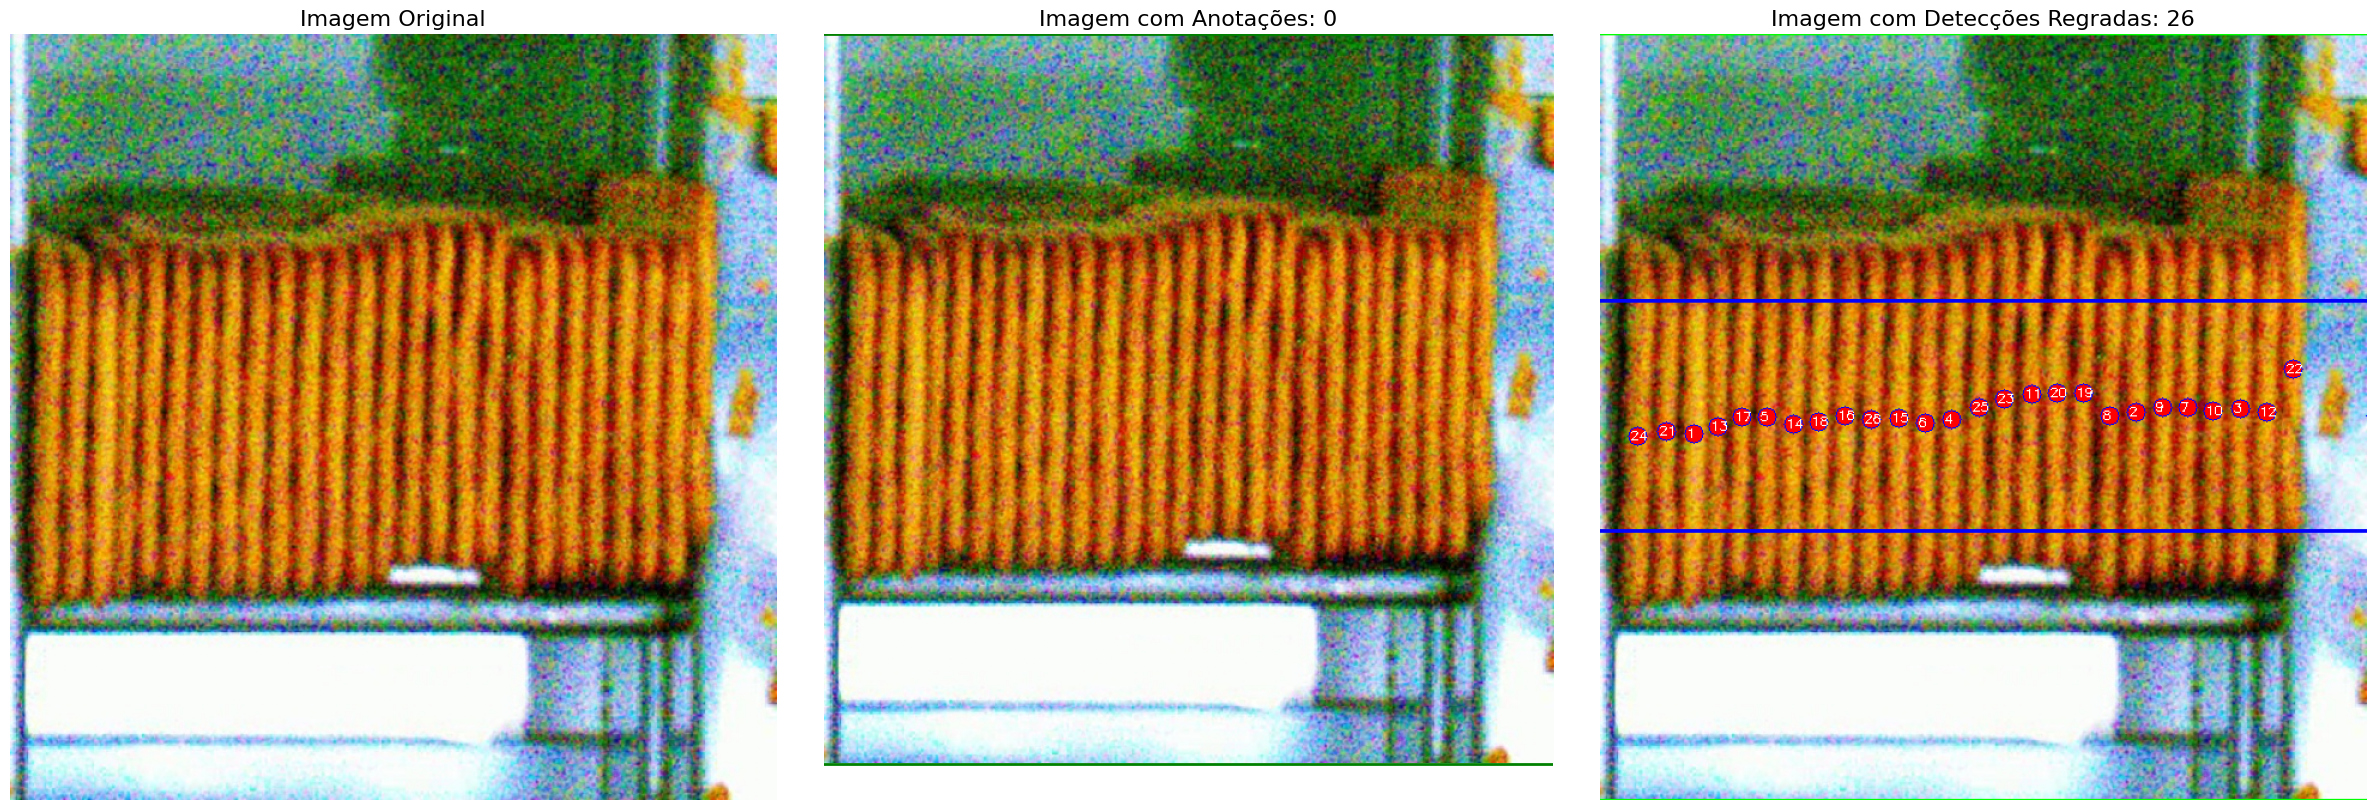

False


In [44]:
image_path = r'C:\ProjetosPython\PICOS\data\outputs\capturas\SM\SM_14_3_20250605_132604.jpg'
print(f"Modelo no modo de avaliação no dispositivo: {next(model.parameters()).device}") # Verificar se o modelo está no dispositivo correto (GPU ou CPU)

image_tensor = load_image_tensor(image_path)
result = visualize_predictions_image(True, device, model, image_tensor, threshold=0.5, perc_top=0, perc_bottom=1, limit_center = 8)
print(result)
######################################################################################


# 4 Check Geral

In [15]:
import glob

caminho = r'C:\ProjetosPython\PICOS\data\outputs\capturas\CM\*.jpg'
arquivos_jpeg = glob.glob(caminho)

# Apenas os nomes dos arquivos (sem o caminho)
nomes_arquivos = [arq.split('\\')[-1] for arq in arquivos_jpeg]

for arquivo in nomes_arquivos:
    print(arquivo.replace('_CM', '').replace('.jpg', ''))

CM_14_20250603_090315
CM_14_20250603_090316
CM_14_20250603_090317
CM_14_20250603_090318
CM_14_20250603_090319
CM_14_20250603_090320
CM_14_20250603_090321
CM_14_20250603_090322
CM_14_20250603_090323
CM_14_20250603_090324
CM_14_20250603_090325
CM_14_20250603_090326
CM_14_20250603_090327
CM_14_20250603_090328
CM_14_20250603_090329
CM_14_20250603_090330
CM_14_20250603_090331
CM_14_20250603_090332
CM_14_20250603_090333
CM_14_20250603_090334
CM_14_20250603_090335
CM_14_20250603_090336
CM_14_20250603_090337
CM_14_20250603_090338
CM_14_20250603_090339
CM_14_20250603_090340
CM_14_20250603_090341
CM_14_20250603_090342
CM_14_20250603_090343
CM_14_20250603_090344
CM_14_20250603_090345
CM_14_20250603_090346
CM_14_20250603_090347
CM_14_20250603_090348
CM_14_20250603_090349
CM_14_20250603_090350
CM_14_20250603_090351
CM_14_20250603_090352
CM_14_20250603_090353
CM_14_20250603_090354
CM_14_20250603_090355


In [3]:
def check_geral(threshold, limit_center, print_images = False):
    base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    images_dir = r'data/inputs/train_images/COCO_20250604/valid'  
    annotations_path = fr'{images_dir}/_annotations.coco.json'  

    with open(os.path.join(base_dir, annotations_path)) as f:
            coco_data = json.load(f)

    num_images = len(coco_data['images'])

    list_correct = []
    list_incorrect = []
    for image_choice in range(0, num_images):
            image_path, annotations, image_file = select_image(images_dir, image_choice)
            image_tensor = load_image_tensor(image_path)
            result = visualize_predictions_image(print_images, device, model, image_tensor, annotations, threshold=threshold, limit_center=limit_center, perc_top=0, perc_bottom=1)

            if result == True:
                list_correct.append(image_path)
                print(f"✅ Correto (C:{len(list_correct)} | I:{len(list_incorrect)}) ({len(list_correct)/(len(list_correct) + len(list_incorrect)) * 100:.2f}%):  {image_path}")


            else: 
                list_incorrect.append(image_path)
                print(f"❌ Incorreto (C:{len(list_correct)} | I:{len(list_incorrect)}) ({len(list_correct)/(len(list_correct) + len(list_incorrect)) * 100:.2f}%):  {image_path}")

    print('--------------------------------------------------------------------------------------')
    print(f' Resultado Final: {len(list_correct)/(len(list_correct) + len(list_incorrect)) * 100:.2f}%')

    return len(list_correct)/(len(list_correct) + len(list_incorrect))

In [ ]:
threshold = 0.5
limit_center = 15
result = check_geral(threshold=threshold, limit_center=limit_center, print_images=True)

In [7]:
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
limit_center_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

print_images = False

best_result = 0.0
for threshold in threshold_list:
    for limit_center in limit_center_list:
        result = check_geral(threshold=threshold, limit_center=limit_center)

        if result > best_result:
            best_result = result
            best_threhold = threshold
            best_limit_center = limit_center

Anotacoes: 27 / Deteccoes: 97
❌ Incorreto (C:0 | I:1) (0.00%):  c:\ProjetosPython\PICOS\data/inputs/train_images/COCO_20250604/valid\SM_14_20250603_090351_jpg.rf.7a82c24f20f605cabe9ff9c45144ef8e.jpg
Anotacoes: 27 / Deteccoes: 97
❌ Incorreto (C:0 | I:2) (0.00%):  c:\ProjetosPython\PICOS\data/inputs/train_images/COCO_20250604/valid\SM_14_20250603_090332_jpg.rf.e5a45d14b47af67361247f1da574ac60.jpg
Anotacoes: 26 / Deteccoes: 98
❌ Incorreto (C:0 | I:3) (0.00%):  c:\ProjetosPython\PICOS\data/inputs/train_images/COCO_20250604/valid\SM_14_20250603_090349_jpg.rf.029f2519ed8a2039b3ce321e8f1d06fe.jpg
Anotacoes: 26 / Deteccoes: 97
❌ Incorreto (C:0 | I:4) (0.00%):  c:\ProjetosPython\PICOS\data/inputs/train_images/COCO_20250604/valid\SM_14_20250603_090333_jpg.rf.518746cba97698692bc1c6a92994f85c.jpg
Anotacoes: 25 / Deteccoes: 97
❌ Incorreto (C:0 | I:5) (0.00%):  c:\ProjetosPython\PICOS\data/inputs/train_images/COCO_20250604/valid\SM_14_20250603_090342_jpg.rf.9524e45a6841f3a776d5659eec5a2ba1.jpg
Anota

In [8]:
print(best_result)
print(best_threhold)
print(best_limit_center)

0.875
0.7
13
